In [54]:
import pandas as pd
import matplotlib.pyplot as plt
groundtruth_df = pd.read_csv('/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_GroundTruth.csv')
metadata_df = pd.read_csv('/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_Input/metadata.csv')
metadata_df = metadata_df.dropna(subset=['age_approx', 'sex', 'anatom_site_general'])
metadata_df['is_60_plus'] = (metadata_df.age_approx >= 60).astype(int)
metadata_df['is_head_neck'] = (metadata_df.anatom_site_general == 'head/neck').astype(int)


df = metadata_df.merge(groundtruth_df, on='isic_id')


In [55]:
import tensorflow as tf
import numpy as np
import os

IMG_SIZE = (224, 224) 
IMAGE_DIR = '/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_Input'

def load_image(isic_id):
    path = os.path.join(IMAGE_DIR, isic_id + '.jpg')
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # normalize
    return image


In [56]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

df.head()

X_metadata = df[['is_60_plus', 'is_head_neck']].values.astype(np.float32)
##X_image = np.stack([load_image(isic_id).numpy() for isic_id in df['isic_id']])
y = df['malignant'].values

# Split all three together (image, metadata, label)
X_meta_train, X_meta_val, y_train, y_val = train_test_split( X_metadata, y, test_size=0.2, random_state=42)

## Naive model: Metadata one-hots only model
     Only use one-hot variables for head/neck & 60+plus age

In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define model
meta_model = models.Sequential([
    layers.Input(shape=(2,)),                 # 2 binary features
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')     # Binary output
])

# Compile
meta_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train on metadata only
meta_model.fit(
    X_meta_train, y_train,
    validation_data=(X_meta_val, y_val),
    epochs=10,
    batch_size=64
)


# Evaluate accuracy on validation set
loss, acc = meta_model.evaluate(X_meta_val, y_val)
print(f"Validation Accuracy: {acc:.3f}")

Epoch 1/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 3s 467us/step - accuracy: 0.9984 - loss: 0.0857 - val_accuracy: 0.9990 - val_loss: 0.0078
Epoch 2/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step - accuracy: 0.9990 - loss: 0.0075 - val_accuracy: 0.9990 - val_loss: 0.0077
Epoch 3/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 474us/step - accuracy: 0.9990 - loss: 0.0079 - val_accuracy: 0.9990 - val_loss: 0.0077
Epoch 4/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 457us/step - accuracy: 0.9990 - loss: 0.0078 - val_accuracy: 0.9990 - val_loss: 0.0077
Epoch 5/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 467us/step - accuracy: 0.9991 - loss: 0.0073 - val_accuracy: 0.9990 - val_loss: 0.0078
Epoch 6/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 456us/step - accuracy: 0.9989 - loss: 0.0080 - val_accuracy: 0.9990 - val_loss: 0.0077
Epoch 7/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 464us/step - accuracy: 0.9990 - loss: 0.0079 - val_accuracy: 0.9990 - val_loss: 0.0077
Epoch 8/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 475us/step - accuracy: 0.9990 -

2387/2387 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step


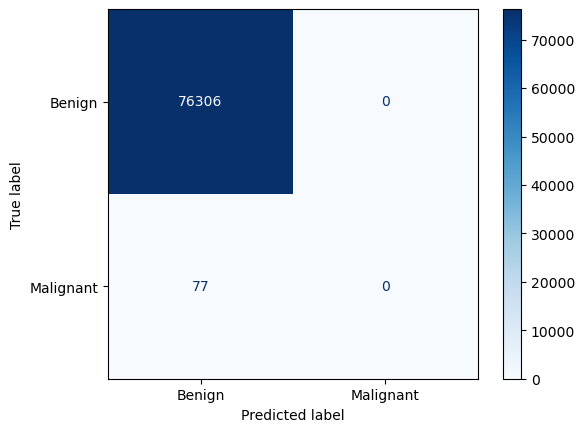

In [58]:
# Predict probabilities on validation set
y_pred_probs = meta_model.predict(X_meta_val)

# Convert probabilities to class predictions (0 or 1)
y_pred = (y_pred_probs >= 0.5).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Optional: plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap='Blues')



#### Evaluation of simple model 1

* the model is predicting 100% benign. it's simply not predicting malignant as so few of the images in this index are malignatn
* it seems like the model learned to simply always guess the majority class, which given the sharp class imbalance, optimizes for accuracy
* _what to change/do differently_: 
    * apply class weights in the loss function to overweight the corrective effects incorrect predictions have.
    * in the model below, we specifically apply a weight such that if malignant cases are x% of the data, they are weighted approximately 1/x times more to contribute equivalently to the corrective model

In [59]:
# Manually compute class weights
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))

print(class_weight_dict)

meta_model.fit(
    X_meta_train, y_train,
    validation_data=(X_meta_val, y_val),
    epochs=10,
    batch_size=64,
    class_weight=class_weight_dict 

)

{0.0: 0.5004979900205421, 1.0: 502.5180921052632}
Epoch 1/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 466us/step - accuracy: 0.8316 - loss: 0.9573 - val_accuracy: 0.4570 - val_loss: 0.6415
Epoch 2/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 477us/step - accuracy: 0.4592 - loss: 0.6646 - val_accuracy: 0.4570 - val_loss: 0.5986
Epoch 3/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 460us/step - accuracy: 0.4849 - loss: 0.6865 - val_accuracy: 0.4570 - val_loss: 0.6706
Epoch 4/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 460us/step - accuracy: 0.6622 - loss: 0.6572 - val_accuracy: 0.4570 - val_loss: 0.7005
Epoch 5/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 452us/step - accuracy: 0.5546 - loss: 0.6588 - val_accuracy: 0.4570 - val_loss: 0.6639
Epoch 6/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 469us/step - accuracy: 0.5929 - loss: 0.6872 - val_accuracy: 0.4570 - val_loss: 0.6647
Epoch 7/10
4774/4774 ━━━━━━━━━━━━━━━━━━━━ 2s 458us/step - accuracy: 0.6119 - loss: 0.6533 - val_accuracy: 0.4570 - val_loss: 0.7390
Epoch 8/10
4774/4774 ━━━━━

2387/2387 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step


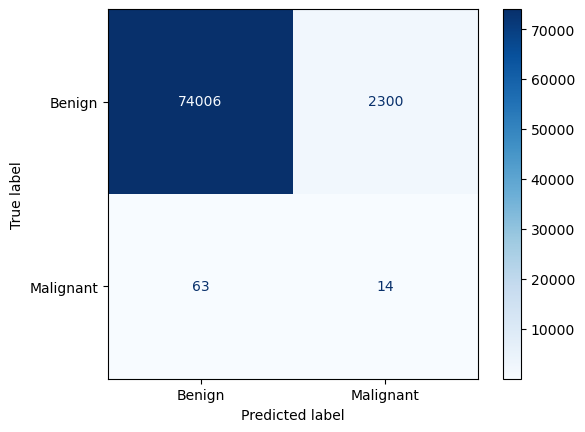

In [60]:
# Predict probabilities on validation set
y_pred_probs = meta_model.predict(X_meta_val)

# Convert probabilities to class predictions (0 or 1)
y_pred = (y_pred_probs >= 0.5).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Optional: plot it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(cmap='Blues')

### final metadata model analysis:
* this model has an extremely high false positivity rateas  a huge portion of benign lesions (over 50%) are classified as malignant
* in spite of the false positivty issues, its recall is a solid 71% of the few malignant cases
* obviously, this is an incomplete model that discards a host of additional metadata features and all of the visual cues offered by images. to account for this, we will compare it to a simple CNN built off the images in our dataset next. 

## Images-only CNN:

In [61]:
import tensorflow as tf
import pandas as pd
import os

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
IMG_DIR = '/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_Input'

# step 1: take first 10,000 rows of the dataframe
df = df[['isic_id', 'malignant']][:10000]

# step 2. pull images by calling their path & label (given by isic id)
def path_label_pair(row):
    img_path = os.path.join(IMG_DIR, str(row['isic_id']) + '.jpg')
    return img_path, float(row['malignant'])

image_paths, labels = zip(*df.apply(path_label_pair, axis=1))
image_paths = list(map(str, image_paths))   # ensure string paths
labels = list(map(float, labels))           # ensure float labels

# step 3. train test split - 80/20 test/val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# step 4. set up preprocessing
def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, tf.cast(label, tf.float32)

# step 5: augment data by flipping & zooming randomly
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def preprocess_train(path, label):
    image, label = preprocess(path, label)
    image = data_augmentation(image)
    return image, label

## step 6: build training & validation datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_ds = (
    train_ds
    .map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    val_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [62]:

def build_cnn(input_shape=(224, 224, 3)):
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(2, 2),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),

        # Classifier
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary output
    ])
    return model

cnn_model = build_cnn()
cnn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)




/Users/pedro.josealvarez/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [67]:
## implement class weight adjustments 
from sklearn.utils.class_weight import compute_class_weight
# Convert float labels to int
train_labels = np.array(train_labels).astype(int)
val_labels = np.array(val_labels).astype(int)

class_weight_dict[1] *= 2.0

class_weight_dict = dict(zip(np.unique(train_labels), class_weights))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=3, restore_best_weights=True)


history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=5, class_weight=class_weight_dict, callbacks = [callback])

Epoch 1/5


250/250 ━━━━━━━━━━━━━━━━━━━━ 90s 354ms/step - accuracy: 0.7438 - auc: 0.3773 - loss: 10.0325 - val_accuracy: 0.0140 - val_auc: 0.5088 - val_loss: 0.7556
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 96s 380ms/step - accuracy: 0.1972 - auc: 0.4314 - loss: 29.6723 - val_accuracy: 0.0135 - val_auc: 0.5070 - val_loss: 0.8056
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 94s 371ms/step - accuracy: 0.0882 - auc: 0.3458 - loss: 13.0598 - val_accuracy: 0.0115 - val_auc: 0.5055 - val_loss: 0.7036
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 92s 363ms/step - accuracy: 0.4972 - auc: 0.3660 - loss: 0.7847 - val_accuracy: 0.0035 - val_auc: 0.5053 - val_loss: 0.7898


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.0128 - auc: 0.1512 - loss: 0.7557


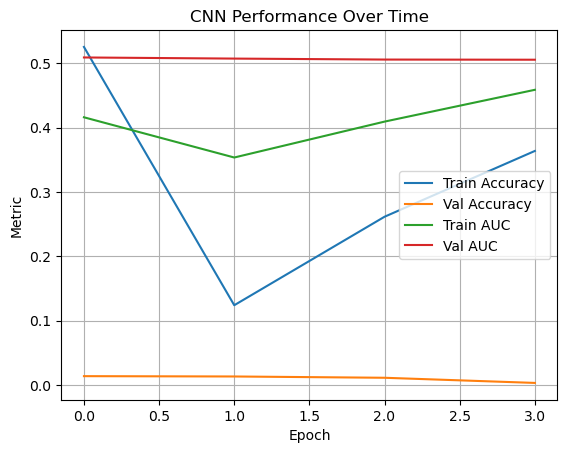

In [68]:
cnn_model.evaluate(val_ds)

# If you want to plot training curves:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('CNN Performance Over Time')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

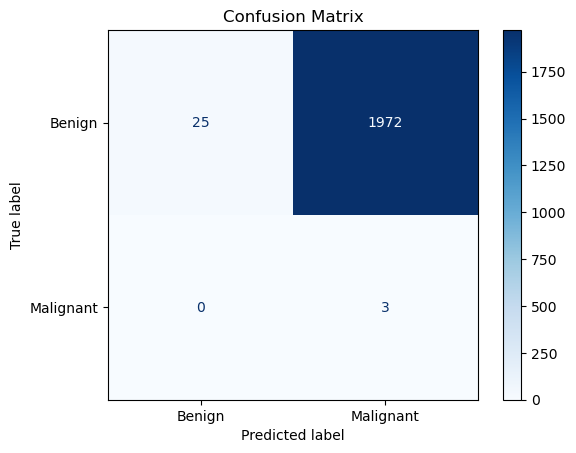

In [69]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Get model predictions on validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = cnn_model.predict(images).flatten()
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# 2. Convert probabilities to binary (0 or 1)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# 3. Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])

# 4. Plot
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()
